In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")

In [5]:
def individual_generator(id_=-1, cb_init=None):
    return Solution(GRNMain(5, 0, 1, generate_funcs=cb_init), id_=id_)

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    last_time = max(stats.time)
    stats = stats.set_index("time")
    prog = stats.loc[last_time]["progenitor_pop_size"]
    neuron = stats.loc[last_time]["neuron_pop_size"]
    # print(prog, neuron, neuron - prog**1.8)

    return 1 / max(1, 1000 + (neuron - prog**1.8))

In [8]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [9]:
def get_bb(prun, grn):
    ccls = factories["grn4"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [10]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [11]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [12]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=0.05, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [13]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    # ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    # ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [14]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [15]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // 100
            exporter(pop[-prun.max_pop:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [16]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [17]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "check_simple_obj_r2"
res = main(prun)

Exporting at output/check_simple_obj_r2
[definition] 
    
    
[reload] Found generation 25
[out] Step 1300
[out] ++ Best 1295.1680276135203 for generation 1300
Step 3 passed !
[out] ++ Best 3057.379702849548 for generation 1302


KeyboardInterrupt: 

In [18]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r2


In [19]:
sm = read_model("generation")

In [20]:
res = pick_best(exp.load(pick_last(exp)))

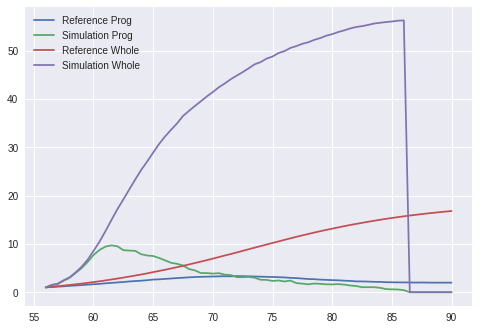

In [21]:
show_curve(res.stats, REF.stats)

In [22]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} =======")
    print(res.grn)


======= GENERATION generation_g0 =======
>> G_0: init: 1.57; noise: 0.13; b: 1.16; m: 5.36; expr: 1.00; deg: 0.10; theta: 7.03; asym: 5.00; tree : ((3 OR 2) OR (4 OR 0))
>> G_1: init: 0.50; noise: 0.44; b: 0.55; m: 9.13; expr: 1.00; deg: 0.10; theta: 7.91; asym: 5.00; tree : 3
>> G_2: init: 0.92; noise: 0.52; b: 1.25; m: 8.77; expr: 1.00; deg: 0.10; theta: 2.90; asym: 5.00; tree : (4 OR 3)
>> G_3: init: 2.30; noise: 0.22; b: 3.84; m: 5.51; expr: 1.00; deg: 0.10; theta: 3.41; asym: 5.00; tree : 5
>> G_4: init: 0.39; noise: 0.32; b: 1.33; m: 1.12; expr: 1.00; deg: 0.10; theta: 3.51; asym: 4.12; tree : 5

======= GENERATION generation_g1 =======
>> G_0: init: 1.03; noise: 0.45; b: 2.35; m: 9.69; expr: 1.00; deg: 0.10; theta: 0.14; asym: 5.00; tree : 0
>> G_1: init: 0.31; noise: 0.06; b: 4.16; m: 4.87; expr: 1.00; deg: 0.10; theta: 4.00; asym: 5.00; tree : 0
>> G_2: init: 0.04; noise: 0.49; b: 1.39; m: 2.73; expr: 1.00; deg: 0.10; theta: 0.81; asym: 5.00; tree : ((4 OR 5) AND (2 AND 3))
>